<a href="https://colab.research.google.com/github/natsakh/IAD/blob/main/Pr_5/5_7_Autoencoder_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random

torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [2]:
# MNIST dataset (images 28x28 → tensors in [0,1])
transform = transforms.ToTensor()

train_set = datasets.MNIST(root="./data", train=True,  download=True, transform=transform)
test_set  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=256, shuffle=False)

input_dim  = 28*28
latent_dim = 32

In [3]:
# Encoder і Decoder
class Encoder(nn.Module):
    def __init__(self, in_dim=input_dim, z_dim=latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128), nn.ReLU(),
            nn.Linear(128, 64),     nn.ReLU(),
            nn.Linear(64, z_dim)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)   # [B,1,28,28] -> [B,784]
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, z_dim=latent_dim, out_dim=input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 64),   nn.ReLU(),
            nn.Linear(64, 128),     nn.ReLU(),
            nn.Linear(128, out_dim),
            nn.Sigmoid()    # щоб відновлені значення були в [0,1]
            )
    def forward(self, z):
        x_hat = self.net(z)
        return x_hat.view(z.size(0), 1, 28, 28)  # назад у форму зображення


In [4]:
# Комбінована модель Autoencoder (encoder + decoder)
class Autoencoder(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

encoder = Encoder().to(device)
decoder = Decoder().to(device)
ae = Autoencoder(encoder, decoder).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)


In [5]:
# Навчання
epochs = 15
for epoch in range(epochs):
    ae.train()
    run_loss = 0.0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_hat = ae(x)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
    print(f"[{epoch+1:02d}] loss={run_loss/len(train_loader):.4f}")



[01] loss=0.2480
[02] loss=0.1585
[03] loss=0.1382
[04] loss=0.1271
[05] loss=0.1202
[06] loss=0.1156
[07] loss=0.1116
[08] loss=0.1079
[09] loss=0.1048
[10] loss=0.1024
[11] loss=0.1003
[12] loss=0.0986
[13] loss=0.0972
[14] loss=0.0960
[15] loss=0.0949


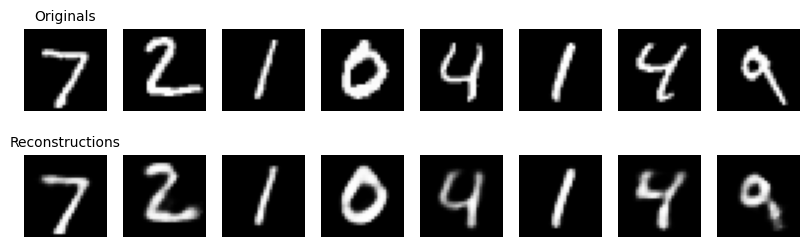

In [6]:
# 5) Використання: encode → decode
import matplotlib.pyplot as plt

ae.eval()
with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x.to(device)[:8]
    z = encoder(x)           # окремо кодуємо
    x_rec = decoder(z)       # окремо декодуємо

# Візуалізація
fig, ax = plt.subplots(2, 8, figsize=(10,3))
for i in range(8):
    ax[0,i].imshow(x[i,0].cpu(), cmap="gray");     ax[0,i].axis("off")
    ax[1,i].imshow(x_rec[i,0].cpu(), cmap="gray"); ax[1,i].axis("off")
ax[0,0].set_title("Originals", fontsize=10)
ax[1,0].set_title("Reconstructions", fontsize=10)
plt.show()


<font size="5"><b>Denoising AE</b></font><br>

вхід = зашумлене зображення x_noisy

вихід = чисте зображення x_clean

loss рахуємо між виходом моделі та x_clean.

In [7]:
d_encoder = Encoder().to(device)
d_decoder = Decoder().to(device)
denoising_ae = Autoencoder(d_encoder, d_decoder).to(device)

In [8]:
noise_factor = 0.4
criterion = nn.BCELoss()  # якщо вихід з Sigmoid і дані в [0,1]
optimizer = torch.optim.Adam(denoising_ae.parameters(), lr=1e-3)
epochs = 15
for epoch in range(epochs):
    denoising_ae.train()
    run_loss = 0.0
    for x_clean, _ in train_loader:            # x_clean ∈ [0,1]
        x_clean = x_clean.to(device)
        # додаємо шум на льоту
        x_noisy = x_clean + noise_factor * torch.randn_like(x_clean)
        x_noisy = x_noisy.clamp(0., 1.)         # тримаємо в [0,1]

        optimizer.zero_grad()
        x_hat = denoising_ae(x_noisy)           # подаємо шумний вхід
        loss = criterion(x_hat, x_clean)        # порівнюємо з чистим
        loss.backward()
        optimizer.step()

        run_loss += loss.item()
    print(f"[{epoch+1}] loss={run_loss/len(train_loader):.4f}")


[1] loss=0.2641
[2] loss=0.1877
[3] loss=0.1599
[4] loss=0.1509
[5] loss=0.1454
[6] loss=0.1413
[7] loss=0.1372
[8] loss=0.1331
[9] loss=0.1297
[10] loss=0.1271
[11] loss=0.1252
[12] loss=0.1237
[13] loss=0.1223
[14] loss=0.1209
[15] loss=0.1199


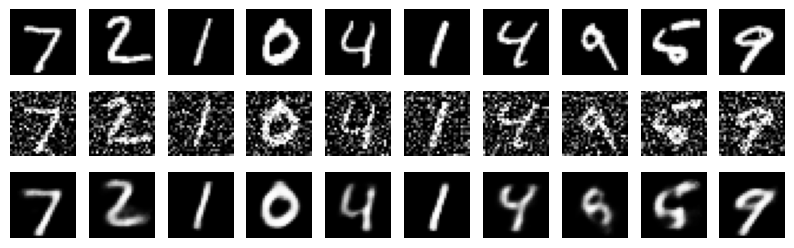

In [9]:
# беремо 10 прикладів з тестового набору
x_clean, _ = next(iter(test_loader))
x_clean = x_clean[:10].to(device)
x_noisy = (x_clean + 0.4 * torch.randn_like(x_clean)).clamp(0., 1.)

# пропускаємо через автоенкодер
denoising_ae.eval()
with torch.no_grad():
    x_denoised = denoising_ae(x_noisy).cpu()

# переносимо на CPU і конвертуємо у numpy
x_clean = x_clean.cpu().numpy()
x_noisy = x_noisy.cpu().numpy()
x_denoised = x_denoised.numpy()

# побудова 3 рядів по 10 зображень
n = 10
plt.figure(figsize=(10, 3))

for i in range(n):
    # оригінал
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_clean[i].reshape(28, 28), cmap="gray")
    ax.axis("off")

    # зашумлене
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_noisy[i].reshape(28, 28), cmap="gray")
    ax.axis("off")

    # відновлене
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(x_denoised[i].reshape(28, 28), cmap="gray")
    ax.axis("off")

plt.show()
